In [2]:
import findspark
findspark.init('/home/ayoubgrm/spark')
#import modules
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.mllib.evaluation import MulticlassMetrics


# nltk
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#create Spark session
appName = "Sentiment Analysis in Spark"
spark = SparkSession.builder.appName(appName).config("spark.some.config.option", "some-value").getOrCreate()

In [3]:
#read csv file into dataFrame with automatically inferred schema
schema = StructType([
         StructField('sentiment', IntegerType()),
         StructField('ids', StringType()),
         StructField('date', StringType(), True),
         StructField('flag', StringType(), True),
         StructField('user', StringType()),
         StructField('text', StringType())
         ])
tweets_csv = spark.read.csv('file:///home/ayoubgrm/Documents/projets/deepLearning/senti140/training.1600000.processed.noemoticon.csv', schema=schema)
tweets_csv.show(truncate=False, n=3)

+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sentiment|ids       |date                        |flag    |user           |text                                                                                                               |
+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0        |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0        |1467810917|Mon Apr 06 22

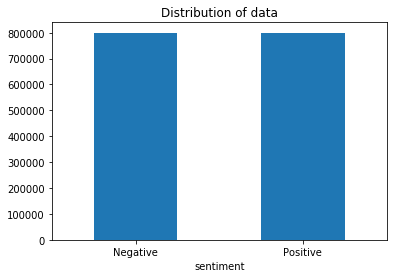

In [4]:
# converting spark dataframe to pandas
#dataset = pd.concat([tweets_csv.select('sentiment','text').toPandas().head(50000),tweets_csv.select('sentiment','text').toPandas().tail(50000)])
dataset = tweets_csv.select('sentiment','text').toPandas()
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [5]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', '>-)':
          'evilgrin', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', 
          ':-O': 'surprised', ':-*': 'kissing', ':-@': 'shocked', ':-$': 'confused',
          ':-\\': 'annoyed', ':-#': 'mute', '(((H)))': 'hugs', ':-X': 'kissing',
          '`:-)': 'smile', ':^)': 'smile', ':-&': 'confused', '<:-)': 'smile', 
          ':->': 'smile', '(-}{-)': 'kissing', ':-Q': 'smoking','$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':*)': 'smile',
          ':@': 'shocked',':-0': 'yell', ':-----)': 'liar', '%-(': 'confused',
          '(:I': 'egghead', '|-O': 'yawning', ':@)': 'smile', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', '~:0': 'baby', '-@--@-': 'eyeglass',
          ":'-)": 'sadsmile', '{:-)': 'smile', ';)': 'wink', ';-)': 'wink', 
          'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [6]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    snowStem = SnowballStemmer("english")
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,'URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,'USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''           
        for word in tweet.split():            
            if len(word)>1:    
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                # Stemming the word.
                word = snowStem.stem(word)
                tweetwords += (word+' ')
                    
        processedText.append(tweetwords)
        
    return processedText

In [7]:
processedtext = preprocess(text)
print('Text Preprocessing complete.')

Text Preprocessing complete.


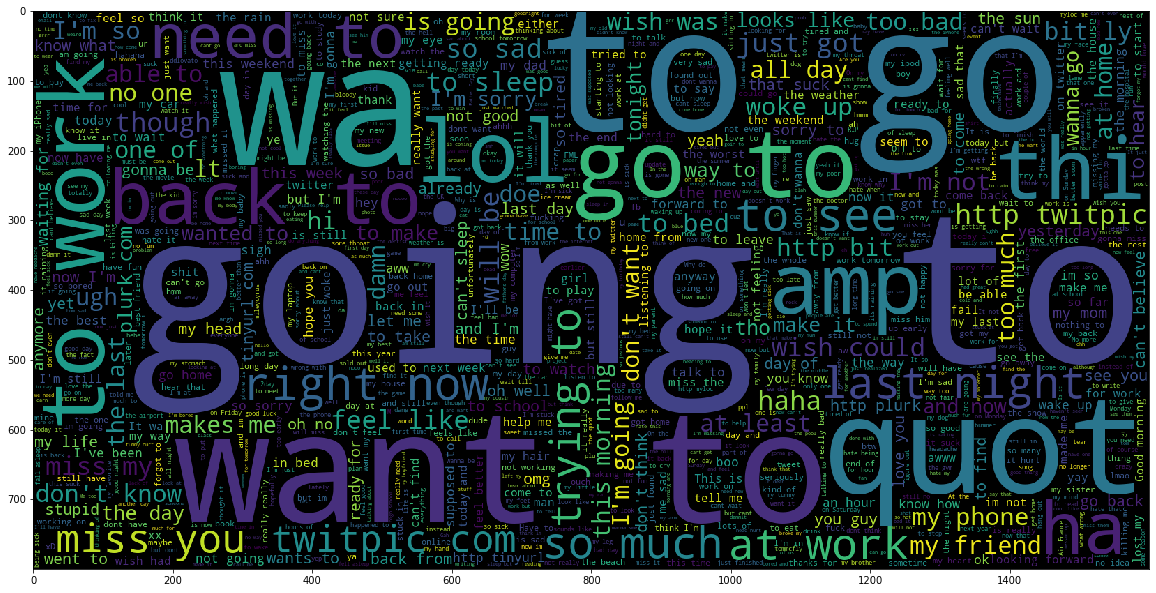

In [8]:
data_neg = dataset['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_neg))
plt.imshow(wc)

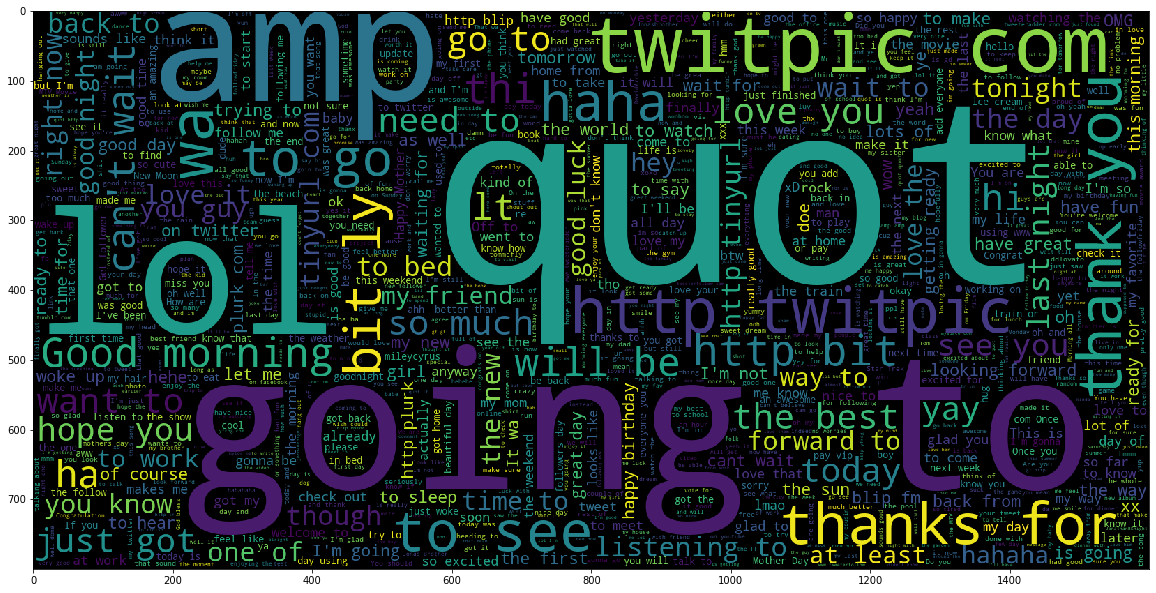

In [9]:
data_pos = dataset['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [10]:
dataset['text'] = processedtext
pdf = spark.createDataFrame(dataset)
pdf=pdf.filter("text!=''")

In [11]:
#divide data, 70% for training, 30% for testing
dividedData = pdf.randomSplit([0.7, 0.3], seed=12345) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 1119896 ; Testing data rows: 480104


In [12]:
# additional spark dataframe preprocessing
# 1. tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=2)

+---------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------+
|sentiment|text                                                                   |SentimentWords                                                                           |
+---------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------+
|0        |00 09 am and still not done pack tire so how are you guy do fill me in |[00, 09, am, and, still, not, done, pack, tire, so, how, are, you, guy, do, fill, me, in]|
|0        |00 about to sleep can find my remot                                    |[00, about, to, sleep, can, find, my, remot]                                             |
+---------+-----------------------------------------------------------------------+-----------------------------------------------

In [13]:
# 2. remove stop words
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=2)

+---------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------+
|sentiment|text                                                                   |SentimentWords                                                                           |MeaningfulWords                             |
+---------+-----------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------+
|0        |00 09 am and still not done pack tire so how are you guy do fill me in |[00, 09, am, and, still, not, done, pack, tire, so, how, are, you, guy, do, fill, me, in]|[00, 09, still, done, pack, tire, guy, fill]|
|0        |00 about to sleep can find my remot                                    |[00, about, to, sleep, can, find, my, rem

In [14]:
# Converting words feature into numerical feature
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=2)

+---------+--------------------------------------------+-------------------------------------------------------------------------------------------------+
|sentiment|MeaningfulWords                             |features                                                                                         |
+---------+--------------------------------------------+-------------------------------------------------------------------------------------------------+
|0        |[00, 09, still, done, pack, tire, guy, fill]|(262144,[31536,45283,73199,109622,113299,161102,166737,254009],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0        |[00, sleep, find, remot]                    |(262144,[91878,166737,192223,234553],[1.0,1.0,1.0,1.0])                                          |
+---------+--------------------------------------------+-------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [15]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

+---------+------------------------+-------------------------------------------------------+
|sentiment|MeaningfulWords         |features                                               |
+---------+------------------------+-------------------------------------------------------+
|0        |[00, offic, sunday, man]|(262144,[39504,109753,166737,245630],[1.0,1.0,1.0,1.0])|
|0        |[00am, final]           |(262144,[9876,245973],[1.0,1.0])                       |
+---------+------------------------+-------------------------------------------------------+
only showing top 2 rows



In [16]:
def model_Evaluate(model):
    # Predict testing data and calculate the accuracy model
    prediction = model.transform(numericTest)
    predictionFinal = prediction.select(
         "prediction", "sentiment")
    predictionFinal.show(n=5, truncate = False)
    predictionAndLabels=predictionFinal.select(col('sentiment').cast('float'),'prediction')
    paradata=predictionAndLabels.rdd.map(lambda x: [x.sentiment,x.prediction]).collect()
    scoreAndLabels = spark.sparkContext.parallelize(paradata, 2)
    # Instantiate metrics object
    metrics = MulticlassMetrics(scoreAndLabels)
    # Statistics
    print("Class positive\n-----------------")
    print("precision = %s" % (metrics.precision(1.0)))
    print("recall = %s" % (metrics.recall(1.0)))
    print("F1 Measure = %s" % (metrics.fMeasure(1.0, beta=1.0)))
    print("\nClass negative\n-----------------")
    print("precision = %s" % (metrics.precision(0.0)))
    print("recall = %s" % (metrics.recall(0.0)))
    print("F1 Measure = %s" % (metrics.fMeasure(0.0, beta=1.0)))
    print("\nAccuracy-----------------\n%s" % (metrics.accuracy))
    # draw confusion matrix
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    cf_matrix=metrics.confusionMatrix().toArray()
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                    xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Training is done!
Evaluation in progress ...
+----------+---------+
|prediction|sentiment|
+----------+---------+
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
+----------+---------+
only showing top 5 rows

Class positive
-----------------
precision = 0.7663208918242503
recall = 0.7671962745400499
F1 Measure = 0.7667583333333332

Class negative
-----------------
precision = 0.7672971700275455
recall = 0.7664220511902631
F1 Measure = 0.7668593609435912

Accuracy-----------------
0.7668088580807492


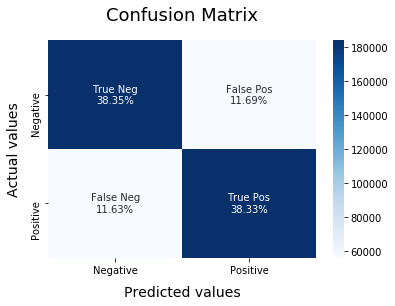

In [17]:
# Train our classifier model using training data
nb = NaiveBayes(labelCol="sentiment", featuresCol="features", 
                        smoothing=1.0, modelType="multinomial")
NBmodel = nb.fit(numericTrainData)
print ("Training is done!\nEvaluation in progress ...")
model_Evaluate(NBmodel)

Training is done!
Evaluation in progress ...
+----------+---------+
|prediction|sentiment|
+----------+---------+
|0.0       |0        |
|0.0       |0        |
|1.0       |0        |
|0.0       |0        |
|0.0       |0        |
+----------+---------+
only showing top 5 rows

Class positive
-----------------
precision = 0.7797174113110433
recall = 0.7578930751420754
F1 Measure = 0.7686503595114011

Class negative
-----------------
precision = 0.750744894089604
recall = 0.77302061342533
F1 Measure = 0.7617199309118661

Accuracy-----------------
0.76523628213887


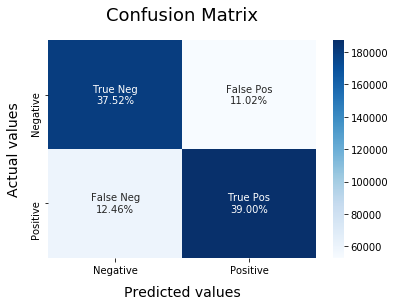

In [18]:
# Train our classifier model using training data
lr = LogisticRegression(labelCol="sentiment", featuresCol="features", 
                        maxIter=10, regParam=0.01)
LRmodel = lr.fit(numericTrainData)
print ("Training is done!\nEvaluation in progress ...")
model_Evaluate(LRmodel)

Training is done!
Evaluation in progress ...
+----------+---------+
|prediction|sentiment|
+----------+---------+
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
|0.0       |0        |
+----------+---------+
only showing top 5 rows

Class positive
-----------------
precision = 0.7859846670858718
recall = 0.7581420009961599
F1 Measure = 0.7718123138135282

Class negative
-----------------
precision = 0.749082165464418
recall = 0.7776619308841088
F1 Measure = 0.7631045498445177

Accuracy-----------------
0.7675399496775699


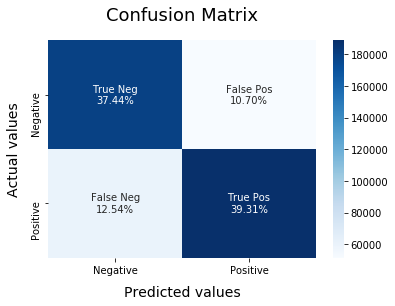

In [20]:
lsvc = LinearSVC(labelCol="sentiment", featuresCol="features",
                 maxIter=10, regParam=0.5)
LSVCmodel = lsvc.fit(numericTrainData)
print ("Training is done!\nEvaluation in progress ...")
model_Evaluate(LSVCmodel)